# Initial Analysis of King County Housing Dataset

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
import sklearn.metrics as metrics

from random import gauss
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

In [3]:
# Reading in .csv, assigning to dataframe `df`
df = pd.read_csv('../data/kc_house_data.csv')

# Shows all columns, i.e. forces pandas/Jupyter
# not to truncate dataframe horizontally
pd.set_option('display.max_columns', False)

In [6]:
# Checking out the data
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,NONE,Average,7 Average,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,NO,NONE,Average,7 Average,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,NO,NONE,Average,6 Low Average,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,NO,NONE,Very Good,7 Average,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,NO,NONE,Average,8 Good,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [7]:
# Checking out the data types and null/non-null counts
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  object 
 9   view           21534 non-null  object 
 10  condition      21597 non-null  object 
 11  grade          21597 non-null  object 
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

In [8]:
# Converting column `date` to datetime64[ns] from type string/object
df['date'] = df['date'].astype('datetime64[ns]')

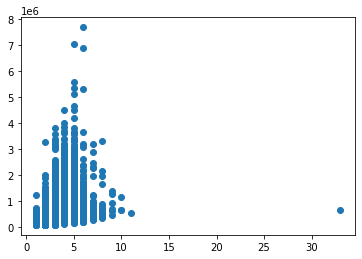

In [10]:
# Experimental basic plot to check out distribution of counts for
# categorical variable `bedrooms`
plt.scatter(x = df['bedrooms'], y = df['price']);

In [39]:
df.price.min()

78000.0

## Initial thoughts

#### The Good
- How should we approach `sqft_living` vs. `sqft_above`? What, if anything, is the difference between these two metrics? `sqft_above` counts living area separate from the basement, but it seems the parameter of interest there is whether or not the house *has* livable basement area.
    - Running a heat map proves that these variables have a colinearity coefficient of `0.88`; it's likely we'll need to choose one or the other for a linear model.
- Because `sqft_living` refers to a record and `sqft_living15` refers to properties in the geographical vicinity of that record, we can compare the values stored in these two columns in a given row to determine if a home's square footage is greater than or less than nearby homes.
    - It might be useful to, early on, perform some simple linear regressions using these as predictor variables to determine goodness of fit, etc.
    
#### The Less Good
- Is `id` going to be useful in any way? It doesn't seem like an instance where a 'unique identifier' is going to provide us with any information we can use for prediction.
    - However! - see "Notes for Cleaning" below.
- We are working with data from a *single county* - will `lat` and `long` be able to tell us anything that we can't glean from, say, zip code? This might also make our presentation and recommendations unnecessarily complex and/or scientific for a business audience.

#### The... Not Sure?
- `yr_renovated` has a fairly substantial number of null values (~4,000), and an even greater number of records with value `0.0`, which likely indicates that no renovation has been done to the house (need to check data dictionary).
    - Heat map examination also indicates a low correlation, < 0.1, between `yr_built` and `price`.   
- `waterfront` may be useful as a boolean value, i.e. to test whether homes located on water are higher priced than homes that we **know** are not located on water.

#### Notes for Cleaning
- Coded null values exist in the following columns:
    - `waterfront`
    - `view`
    - `yr_renovated`
    
- Duplicates exist in the `id` column - these are houses that were sold more than once! What are we going to do about this, and why are we going to go about it that way?

In [25]:
# Dealing with duplicates in the `id` column
# Creating a new copy of the dataframe, sorting
# by columns `id` and `date`
df_copy = df.sort_values(by = ['id', 'date'])
df_copy.drop_duplicates(subset = ['id'],
                        keep = 'last',
                        inplace = True)

print(f"""The original dataset had {df.shape[0]} rows.

After removing duplicates from the 'id' column, i.e. houses with more than one sale,
the dataset has {df_copy.shape[0]} rows.

There were {df.shape[0] - df_copy.shape[0]} houses in the original dataset with multiple sales.""")

The original dataset had 21597 rows.

After removing duplicates from the 'id' column, i.e. houses with more than one sale,
the dataset has 21420 rows.

There were 177 houses in the original dataset with multiple sales.


In [31]:
# DummyRegressor?
from sklearn.dummy import DummyRegressor

dummy_lr = DummyRegressor()

In [28]:
# Creating a straightforward, initial model --
# just for kicks
simple_formula = 'price ~ sqft_living'
simple_model = ols(formula = simple_formula, data = df_copy).fit()

simple_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.492
Model:                            OLS   Adj. R-squared:                  0.492
Method:                 Least Squares   F-statistic:                 2.073e+04
Date:                Mon, 28 Mar 2022   Prob (F-statistic):               0.00
Time:                        09:38:03   Log-Likelihood:            -2.9763e+05
No. Observations:               21420   AIC:                         5.953e+05
Df Residuals:                   21418   BIC:                         5.953e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -4.255e+04   4436.470     -9.591      0.000   -5.12e+04   -3.39e+04
sqft_living   280.5436      1.949    143.972      0.000     276.724     284.363
==============================================================================
Omnibus:                    14710.422   Durbin-Watson:                   1.042
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           541541.173
Skew:                           2.827   Prob(JB):                         0.00
Kurtosis:                      26.975   Cond. No.                     5.64e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.64e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [34]:
dummy_lr = DummyRegressor()

X = df_copy['sqft_living']
y = df_copy['price']

In [35]:
dummy_lr.fit(X,y)

DummyRegressor()

In [36]:
dummy_lr.score(X,y)

0.0

In [42]:
# Some exploratory value counts on columns of interest

# Counting the number of homes with recorded
# waterfront status vs. those without it
df.waterfront.value_counts()

# Number of bathrooms - note that many values exist
# with decimal places, i.e. half baths. This could get
# messy and convoluted quickly.

## df.bathrooms.value_counts()

NO     19075
YES      146
Name: waterfront, dtype: int64

In [ ]:
# Is it possible to loop or function for the below cell?

In [113]:
# Filling null values in column `view` with string indicating
# that no record exists on the property's view
df.view.fillna(value = 'NO_RECORD', inplace = True)

# Filling null values in column `yr_renovated` with integer 0,
# indicating that no renovation year exists for this record
df.yr_renovated.fillna(value = 0, inplace = True)

# Filling null values in column `waterfront` to reflect
# unknown status - this code may go unused
df.waterfront.fillna(value = 'NO_RECORD', inplace = True)

In [111]:
# Creating variables to count values in columns `grade`, `condition`, 
# and `yr_renovated` in King County real estate data

grade_counts = df['grade'].value_counts()
condition_counts = df['condition'].value_counts()
renovation_counts = df['yr_renovated'].value_counts()

# Looping through to see several value counts at once
counts = [grade_counts, condition_counts, renovation_counts]
num = 0

for x in counts:
    num += 1
    column_name = x.name
    print(f"'{column_name.upper()}' value counts:\n{x}\n\n")

'GRADE' value counts:
7 Average        8974
8 Good           6065
9 Better         2615
6 Low Average    2038
10 Very Good     1134
11 Excellent      399
5 Fair            242
12 Luxury          89
4 Low              27
13 Mansion         13
3 Poor              1
Name: grade, dtype: int64


'CONDITION' value counts:
Average      14020
Good          5677
Very Good     1701
Fair           170
Poor            29
Name: condition, dtype: int64


'YR_RENOVATED' value counts:
0.00       17011
2014.00       73
2003.00       31
2013.00       31
2007.00       30
           ...  
1946.00        1
1959.00        1
1971.00        1
1951.00        1
1954.00        1
Name: yr_renovated, Length: 70, dtype: int64




In [19]:
# Dataframe including only columns w/ numerical values
numbers_df = df.select_dtypes('number')

numbers2_df = numbers_df.drop(['id', 'lat', 'long', 'zipcode'], axis = 1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   price          21597 non-null  float64
 2   bedrooms       21597 non-null  int64  
 3   bathrooms      21597 non-null  float64
 4   sqft_living    21597 non-null  int64  
 5   sqft_lot       21597 non-null  int64  
 6   floors         21597 non-null  float64
 7   sqft_above     21597 non-null  int64  
 8   yr_built       21597 non-null  int64  
 9   yr_renovated   17755 non-null  float64
 10  zipcode        21597 non-null  int64  
 11  lat            21597 non-null  float64
 12  long           21597 non-null  float64
 13  sqft_living15  21597 non-null  int64  
 14  sqft_lot15     21597 non-null  int64  
dtypes: float64(6), int64(9)
memory usage: 2.5 MB


In [23]:
# Correlation heatmap

# fig, ax = plt.subplots(figsize = (10,10))

# sns.heatmap(data = numbers2_df.corr(),
#            annot = True);

In [46]:
# Dropping columns we determined were either superfluous or irrelevant
df.drop(columns = ['id', 'sqft_lot', 'floors', 'condition', 'sqft_above', 'sqft_basement',
                   'zipcode', 'lat', 'long', 'sqft_lot15'], inplace = True)
# potentially include yr_renovated? depending on use

In [50]:
# Applied universally to notebook -- converts any scientific notation
# to standard notation, rounded to two decimal places

# Use with caution! Will need to restart kernel to reset effect.

pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [51]:
# Creating new df, grouped by column `view`, and looking
# at mean values for the categorical variables in `view`
view_df = df.groupby('view').mean()

view_df.sort_values('price', ascending = False)

,price,bedrooms,bathrooms,sqft_living,yr_built,yr_renovated,sqft_living15
view,,,,,,,
EXCELLENT,1452465.88,3.62,2.78,3334.48,1965.95,270.18,2841.00
GOOD,973285.20,3.67,2.67,3016.85,1967.39,192.58,2702.21
FAIR,813373.27,3.54,2.35,2571.05,1962.89,151.11,2407.35
AVERAGE,791390.37,3.57,2.43,2650.72,1964.82,106.27,2427.34
NO RECORD,621958.17,3.43,2.15,2249.17,1970.11,31.67,2096.13
NONE,496806.07,3.35,2.07,1998.36,1971.62,59.10,1924.74


Takeaways from this quick analysis of `view` include...

- Clear descending order with `EXCELLENT` at top and `NONE` at bottom
- Significant differences between `EXCELLENT` and middle `view` values, and between middle `view` values and `NONE`
    - Differences not as significant between `GOOD`, `FAIR`, and `AVERAGE`
- `NO RECORD` (formerly null/NaN) will need further investigation, as it seems to lie between `AVERAGE` (i.e. **having** a view, but an average one) and `NONE`, which ostensibly means no scenic view whatsoever.
    - Fortunately, we have < 100 null values in this column, so we can either drop them or modify them without worrying about those changes affecting our conclusions significantly.

In [114]:
wf_df = df.groupby('waterfront').mean()

wf_df.sort_values('price', ascending = False)

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
waterfront,,,,,,,,,,,,,,,
YES,4454968693.05,1717214.73,3.35,2.71,3244.75,25870.88,1.63,2508.76,1962.28,395.01,98096.71,47.54,-122.28,2682.83,22893.70
NO,4593352007.42,532641.99,3.37,2.11,2073.52,14991.12,1.49,1785.88,1971.11,65.20,98077.59,47.56,-122.21,1982.05,12729.49
NO_RECORD,4484801440.32,529430.07,3.36,2.11,2063.34,15306.89,1.49,1766.19,1970.68,77.25,98079.69,47.56,-122.21,1980.51,12366.68


### Side notes and things to revisit

- `yr_renovated` has null values and a lot of `0` values too. Of the houses *with* values in the `yr_renovated` column, the vast majority were renovations from 2013 and 2014. It might be worth further exploring how these recently renovated homes compare pricewise to homes built in prior years.